In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import operator


from os.path import join,realpath
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from nltk.probability import FreqDist

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBRegressor, XGBClassifier, XGBRFRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.preprocessing import LabelEncoder

from typing import List

In [30]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [ ]:
%%cython


## Loading in and cleaning


In [27]:
from utils import BASE_DIR, DATA_DIR, process_csv, COLUMNS, shuffle_and_split,outlier
DATA_DIR

'/Users/max/Desktop/Tabular_data/Winequality_dataset/data'

In [17]:
%reload_ext autoreload
%autoreload 2

In [4]:
files = os.listdir(DATA_DIR)
files

['winequality-red.csv',
 'winequality-white.csv',
 'winequality-names.txt',
 'winequality-names.txt.bak']

In [8]:
%timeit red_wine_df = pd.DataFrame(process_csv(files[0]), columns = COLUMNS) 

1.87 ms ± 35.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
%prun -l 5 red_wine_df = pd.DataFrame(process_csv(files[0]), columns = COLUMNS) 

         10881 function calls (10866 primitive calls) in 0.006 seconds

   Ordered by: internal time
   List reduced from 143 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002    0.005    0.005 utils.py:13(process_csv)
        1    0.001    0.001    0.001    0.001 {built-in method io.open}
     1600    0.001    0.000    0.001    0.000 {method 'sub' of 're.Pattern' objects}
     1601    0.001    0.000    0.001    0.000 {method 'split' of 'str' objects}
        1    0.000    0.000    0.006    0.006 <string>:1(<module>)

In [9]:
%prun -l 4 red_wine_df.drop([0], inplace = True) 

         961 function calls (940 primitive calls) in 0.006 seconds

   Ordered by: internal time
   List reduced from 200 to 4 due to restriction <4>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    0.002    0.000    0.002    0.000 base.py:2421(is_boolean)
        4    0.001    0.000    0.003    0.001 base.py:6285(_should_compare)
        2    0.000    0.000    0.000    0.000 range.py:398(_get_indexer)
  158/152    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}

In [34]:
%prun -l 4 red_wine_df = red_wine_df.iloc[1:,:] #This method is faster

         147 function calls in 0.000 seconds

   Ordered by: internal time
   List reduced from 70 to 4 due to restriction <4>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {method 'get_slice' of 'pandas._libs.internals.BlockManager' objects}
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 indexing.py:911(_getitem_tuple_same_dim)

In [ ]:
%prun -l 4 red_wine_df = process_csv_cython(files[0], columns = COLUMNS)

In [36]:
%prun -l 4 for i in COLUMNS: red_wine_df[i] = red_wine_df[i].astype(float)

         5231 function calls (5124 primitive calls) in 0.005 seconds

   Ordered by: internal time
   List reduced from 169 to 4 due to restriction <4>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       12    0.001    0.000    0.001    0.000 {method 'astype' of 'numpy.ndarray' objects}
       22    0.001    0.000    0.001    0.000 {built-in method numpy.empty}
       22    0.000    0.000    0.001    0.000 function_base.py:5054(delete)
       12    0.000    0.000    0.000    0.000 {method 'clear' of 'dict' objects}

<Axes: xlabel='quality', ylabel='Count'>

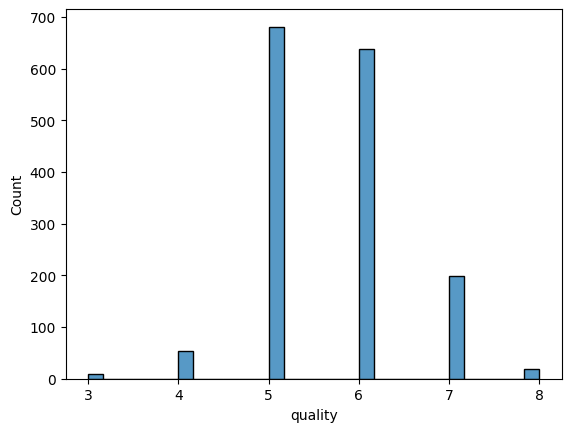

In [37]:
sns.histplot(red_wine_df['quality'])

In [38]:
%prun -l 4 train_df,test_df = shuffle_and_split(red_wine_df, main_var = red_wine_df['quality'])


         1442 function calls (1370 primitive calls) in 0.004 seconds

   Ordered by: internal time
   List reduced from 276 to 4 due to restriction <4>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.001    0.000    0.001    0.000 {method 'argsort' of 'numpy.ndarray' objects}
        3    0.001    0.000    0.001    0.000 {method 'choice' of 'numpy.random.mtrand.RandomState' objects}
    35/24    0.000    0.000    0.002    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        3    0.000    0.000    0.000    0.000 validation.py:1207(check_random_state)

<Axes: xlabel='quality', ylabel='Count'>

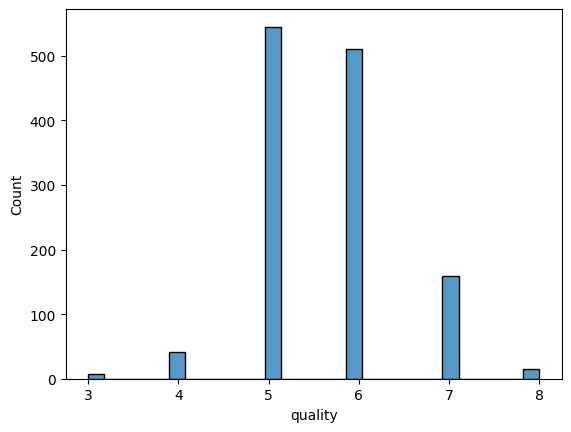

In [8]:
sns.histplot(train_df['quality'])

Train set is unbalanced. Wines with quality 3, 8 have least number of examples. Quality 5 and 6 have a lot of examples, followed by 7, followed by 4. It will be good practice to seperate wines with low numbers for training.

## Exploring data and feature engineering 

Suggestion to add columns on total acidity, fixed sulfur dioxide

In [ ]:
SS = StandardScaler()

#Train data
SS_train_df = SS.fit_transform(train_df)
SS_train_df = pd.DataFrame(SS_train_df, columns = COLUMNS)

SS_train_df['quality'] = train_df['quality']
SS_train_df.dropna(inplace=True)

#Test data
SS_test_df = SS.fit_transform(test_df)
SS_test_df = pd.DataFrame(test_df, columns= COLUMNS)

SS_test_df['quality'] = test_df['quality']
SS_test_df.dropna(inplace = True)

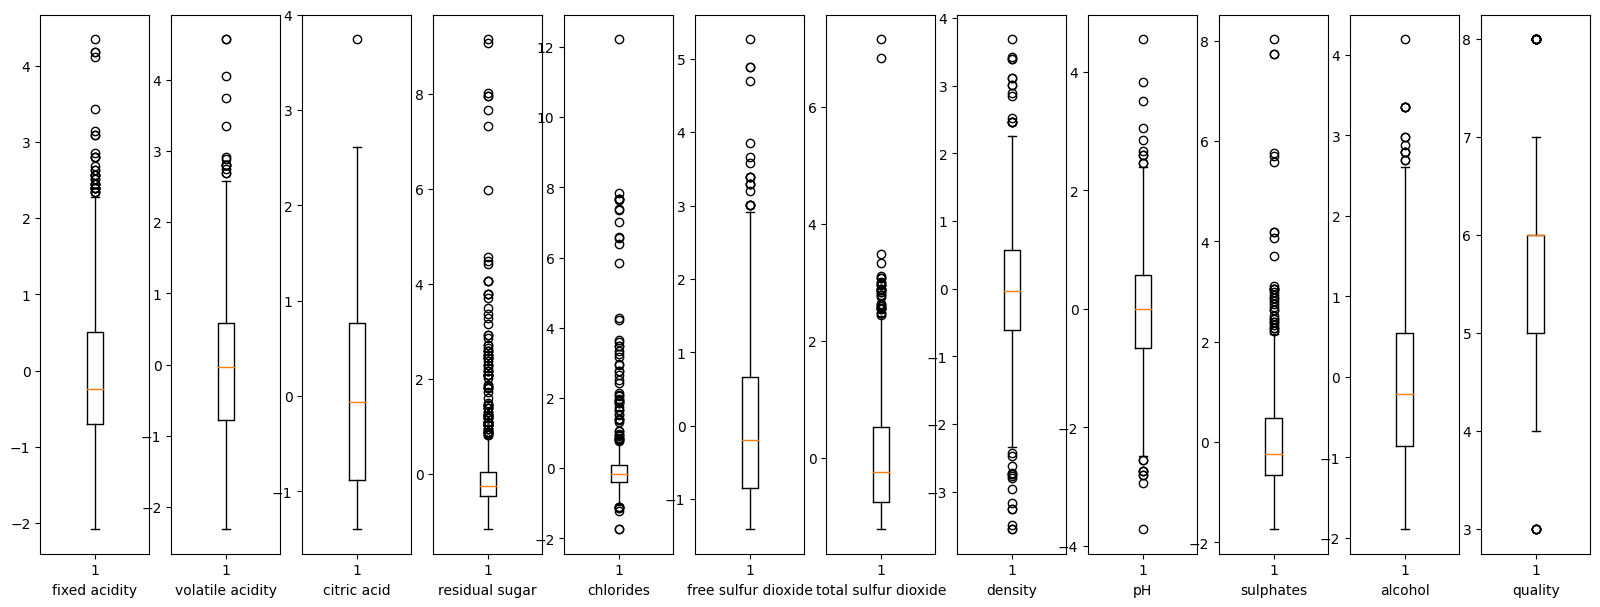

In [ ]:
fig,ax_1 = plt.subplots(1,len(COLUMNS), figsize = (20,7))

for i,item in enumerate(COLUMNS):
    ax_1[i].boxplot(SS_train_df[item].astype(float))
    ax_1[i].set_xlabel(item)

Standardization does not reduce the number of outliers

In [53]:
le = LabelEncoder()
xgc_model = XGBClassifier()

def features_target(df, target = 'quality'):
    "Seperates features and target from target in a supervised training pipeline"
    
    y = le.fit_transform(df[target])
    x = df.drop(columns= 'quality')
    return x,y

%prun -l 5 train_x, train_y = features_target(train_df)


         824 function calls (817 primitive calls) in 0.001 seconds

   Ordered by: internal time
   List reduced from 217 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {method 'argsort' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 arraysetops.py:323(_unique1d)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 warnings.py:130(filterwarnings)
        1    0.000    0.000    0.000    0.000 {method 'cumsum' of 'numpy.ndarray' objects}

In [55]:
def model_ensemble(model, target:str ='quality', encoder = le, sect = [3.0, 4.0, 5.0], train_df = train_df, test_df = test_df):

    """Filters dataset by quality and trains on only selected labels"""

    condition = train_df[target].isin(sect)
    condition_test = test_df[target].isin(sect)

    train_df = train_df.loc[condition]
    test_df = test_df.loc[condition_test]

    y = encoder.fit_transform(train_df[target])
    x = train_df.drop(columns = target)
    
    y_test = encoder.fit_transform(test_df[target])
    x_test = test_df.drop(columns = target)

    model.fit(x,y)
    obtained_y = model.predict(x_test)

    feat = {i:j for i,j in zip(model.feature_names_in_.tolist(), model.feature_importances_.tolist())} 
    print("Accuracy : {}, f1_score : {}".format(accuracy_score(y_test, obtained_y), f1_score(y_test, obtained_y, average = 'weighted')))
    return model,feat,obtained_y,y_test

%prun -l 8 model,feat,obtained_y,y_test = model_ensemble(xgc_model)

Accuracy : 0.9060402684563759, f1_score : 0.8803681323493118
 

         41442 function calls (41333 primitive calls) in 0.156 seconds

   Ordered by: internal time
   List reduced from 673 to 8 due to restriction <8>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    0.129    0.001    0.137    0.001 core.py:1897(update)
      613    0.004    0.000    0.005    0.000 core.py:89(from_cstr_to_pystr)
        2    0.002    0.001    0.004    0.002 core.py:1528(__init__)
        1    0.002    0.002    0.002    0.002 core.py:1656(__getstate__)
      410    0.001    0.000    0.005    0.000 core.py:1820(_get_feature_info)
      100    0.001    0.000    0.001    0.000 core.py:1954(eval_set)
     6825    0.001    0.000    0.001    0.000 {method 'decode' of 'bytes' objects}
        3    0.001    0.000    0.001    0.000 config.py:135(get_config)

In [60]:
import json
file = join(BASE_DIR, "config.json")

def load_config(filepath):
    """Loads config given a filepath"""
    with open(filepath, 'r') as ins:
        params = json.load(ins)
    return params

%prun -l 5 parameters = load_config(file)

         24 function calls in 0.000 seconds

   Ordered by: internal time
   List reduced from 22 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method io.open}
        1    0.000    0.000    0.000    0.000 {method 'read' of '_io.TextIOWrapper' objects}
        1    0.000    0.000    0.000    0.000 272278655.py:4(load_config)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 decoder.py:343(raw_decode)

In [65]:
def random_search(model, parameters = parameters['xgboost'], target:str ='quality', encoder = le, sect = [3.0, 4.0, 5.0], train_df = train_df, test_df = test_df):
    """Tunes Hyperparameters with Random Search CV, parameters should correspond to model type"""

    condition = train_df[target].isin(sect)
    condition_test = test_df[target].isin(sect)

    train_df = train_df.loc[condition]
    test_df = test_df.loc[condition_test]

    y = encoder.fit_transform(train_df[target])
    x = train_df.drop(columns = target)
    
    y_test = encoder.fit_transform(test_df[target])
    x_test = test_df.drop(columns = target)

    gridsearch = RandomizedSearchCV(model, param_distributions= parameters)
    output = []

    gridsearch.fit(x,y)
    print(gridsearch.best_params_)
    
    best_xgb_model = model.set_params(**gridsearch.best_params_)
    best_xgb_model.fit(x, y)
    pred = best_xgb_model.predict(x_test)

    f1 = f1_score(y_test, pred, average = "weighted")
    output.append((f1,best_xgb_model,))
    return output,pred

%prun -l 5 output,pred = random_search(xgc_model, parameters= parameters['xgboost'])

/Users/max/Desktop/Tabular_data/tabular_venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_leaves=None,
                                           min_child_we

         7261404 function calls (7255628 primitive calls) in 18.520 seconds

   Ordered by: internal time
   List reduced from 1058 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    23500   15.446    0.001   17.008    0.001 core.py:1897(update)
   141422    0.740    0.000    1.036    0.000 core.py:89(from_cstr_to_pystr)
       94    0.498    0.005    0.836    0.009 core.py:1528(__init__)
       47    0.324    0.007    0.331    0.007 core.py:1656(__getstate__)
    94328    0.168    0.000    0.919    0.000 core.py:1820(_get_feature_info)

In [20]:
def outlier(df, target:str):
    """Computes outliers on a dataframe using > Q3 + 1.5iqr and < Q1 - 1.5iqr . Returns mask of true outliers,"""
    assert len(df) is not None, 'DataFrame is empty'
    assert target in list(df.columns), 'Target should be in passed dataframe'

    rng= np.quantile(df[target], 0.75) -  np.quantile(df[target], 0.25)
    upper_limit = 1.5*rng + np.quantile(df[target], 0.75)
    lower_limit = np.quantile(df[target], 0.25) - 1.5*rng
    print(lower_limit, upper_limit)

    mask = df[target].isin(np.arange(lower_limit, upper_limit, 0.5))
    return ~mask

mask = outlier(train_df, 'quality')
outlier_df = train_df[mask]
outlier_df

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U1'), dtype('<U1')) -> None

In [23]:
le = LabelEncoder()
xgc_model = XGBClassifier()

y = le.fit_transform(train_df['quality'])
x = train_df.drop(columns= 'quality')

y_test = le.fit_transform(test_df['quality'])
x_test = test_df.drop(columns = 'quality')

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

def conf_mat(pred, true):
    y_pred = le.inverse_transform(pred)
    y_true = le.inverse_transform(true)
    return ConfusionMatrixDisplay.from_predictions(true, pred)

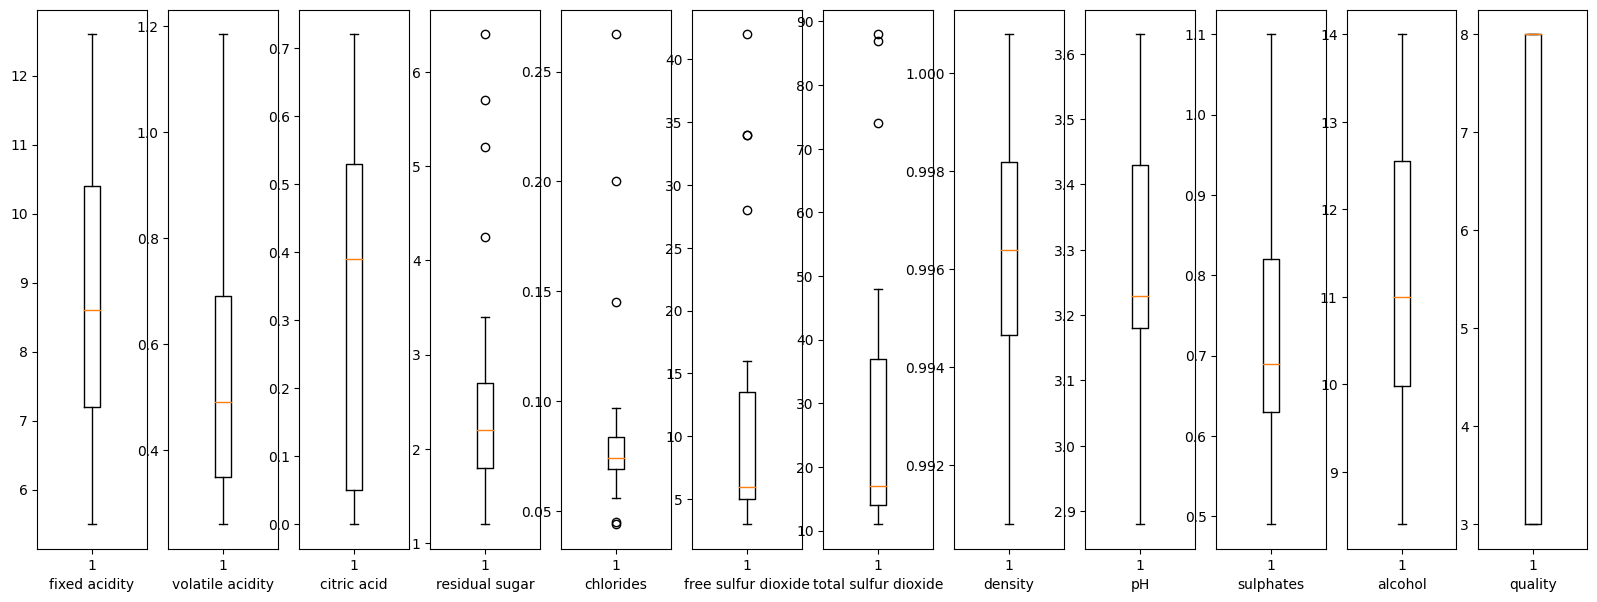

In [21]:
fig,ax_1 = plt.subplots(1,len(columns), figsize = (20,7))
#ax_1.title("Boxplots of outliers")

for i,item in enumerate(columns):
    ax_1[i].boxplot(outlier_df[item].astype(float))
    ax_1[i].set_xlabel(item)

In [22]:
model_3_8, feat_3_8, y_3_8_pred, y_3_8_true  = model_ensemble(xgc_model, sect = [3.0, 8.0])
feat_3_8

Accuracy : 1.0, f1_score : 1.0


{'fixed acidity': 0.0,
 'volatile acidity': 0.15779966115951538,
 'citric acid': 0.0,
 'residual sugar': 0.0,
 'chlorides': 0.08354412019252777,
 'free sulfur dioxide': 0.0,
 'total sulfur dioxide': 0.0,
 'density': 0.0,
 'pH': 0.0605258010327816,
 'sulphates': 0.5521552562713623,
 'alcohol': 0.14597514271736145,
 'total acidity': 0.0,
 'fixed sulfur dioxide': 0.0}

Feature importance shows the metrics that are important in determine if a wine is very good or very bad. Leel of sulphates playing a major role, followed by volatile acidity.
Although sample size is small, it gives a result

In [24]:
test_df[test_df['quality'].isin([3.0, 8.0])]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total acidity,fixed sulfur dioxide
1470,7.3,0.98,0.05,2.1,0.061,20.0,49.0,0.99705,3.31,0.55,9.7,3.0,8.28,29.0
1300,7.6,1.58,0.00,2.1,0.137,5.0,9.0,0.99476,3.50,0.40,10.9,3.0,9.18,4.0
589,5.0,0.42,0.24,2.0,0.060,19.0,50.0,0.99170,3.72,0.74,14.0,8.0,5.42,31.0
268,7.9,0.35,0.46,3.6,0.078,15.0,37.0,0.99730,3.35,0.86,12.8,8.0,8.25,22.0
1550,7.4,0.36,0.30,1.8,0.074,17.0,24.0,0.99419,3.24,0.70,11.4,8.0,7.76,7.0


Possible overfitting due to the low number of training and test data(5)


In [25]:
for i in np.arange(3.0,9.0,1.0):
    print("Quality {} : The minimum measure obtained for chlorides found in the dataframe is {} while the maximum obtained is {}".format(i, train_red_wine_df[train_red_wine_df.loc[:, 'quality'] == i]['chlorides'].min(), train_red_wine_df[train_red_wine_df.loc[:, 'quality'] == i]['chlorides'].max()))
print("\n")
for i in np.arange(3.0,9.0,1.0):
    print("Quality {} : The minimum measure obtained for alcohol found in the dataframe is {} while the maximum obtained is {}".format(i, train_red_wine_df[train_red_wine_df.loc[:, 'quality'] == i]['alcohol'].min(), train_red_wine_df[train_red_wine_df.loc[:, 'quality'] == i]['alcohol'].max()))

Quality 3.0 : The minimum measure obtained for chlorides found in the dataframe is 0.074 while the maximum obtained is 0.267
Quality 4.0 : The minimum measure obtained for chlorides found in the dataframe is 0.045 while the maximum obtained is 0.61
Quality 5.0 : The minimum measure obtained for chlorides found in the dataframe is 0.039 while the maximum obtained is 0.422
Quality 6.0 : The minimum measure obtained for chlorides found in the dataframe is 0.034 while the maximum obtained is 0.415
Quality 7.0 : The minimum measure obtained for chlorides found in the dataframe is 0.012 while the maximum obtained is 0.143
Quality 8.0 : The minimum measure obtained for chlorides found in the dataframe is 0.044 while the maximum obtained is 0.086


Quality 3.0 : The minimum measure obtained for alcohol found in the dataframe is 8.4 while the maximum obtained is 11.0
Quality 4.0 : The minimum measure obtained for alcohol found in the dataframe is 9.0 while the maximum obtained is 12.0
Quality 5

Examining the above to check if there's a visible trend in the individual measures of attributes

In [26]:
#Creating a single model for non-outliers, and treating them differently
model_ensemble(xgc_model, sect = [4.0,5.0,6.0,7.0])

Accuracy : 0.692063492063492, f1_score : 0.6850655553989665


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='multi:softprob', predictor=None, ...),
 {'fixed acidity': 0.07124609500169754,
  'volatile acidity': 0.07979865372180939,
  'citric acid': 0.05643383413553238,
  'residual sugar': 0.059219639748334885,
  'chlorides': 0.06497221440076828,
  'free sulfur dioxide': 0.0

Feature engineering

In [27]:
#using less features
#free sulfur dioxide, fixed acidity  led to drop, pOH, citric acid had no effect
#Model to detect outliers
#Incrementally added features

features = ['sulphates','chlorides','volatile acidity',"quality", "alcohol", "pH", "residual sugar", "total sulfur dioxide"]
model_4567, feat_4567, y_4567_pred, y_4567_true  = model_ensemble(xgc_model, sect = [4.0, 5.0, 6.0, 7.0], train_df = train_red_wine_df[features], test_df = test_df[features])
feat_4567

Accuracy : 0.7047619047619048, f1_score : 0.6917063548881424


{'sulphates': 0.14548835158348083,
 'chlorides': 0.10958532989025116,
 'volatile acidity': 0.13376374542713165,
 'alcohol': 0.25799742341041565,
 'pH': 0.11079487949609756,
 'residual sugar': 0.10713819414377213,
 'total sulfur dioxide': 0.13523204624652863}

In [28]:
mod_4567, pred_4567 = random_search(model_4567, x = train_red_wine_df[features], y = le.fit_transform(train_red_wine_df["quality"]), x_test= test_df[features], y_test = le.fit_transform(test_df["quality"]))
mod_4567

/Users/max/Desktop/Tabular_data/tabular_venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[(0.9858480944712829,
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.7, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.03, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight=4, missing=nan, monotone_constraints=None,
                n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,
                objective='multi:softprob', ...))]

Confusion matrix below shows that the model performs very well in detecting items in each bracket with a f1_score of 0.985

In [ ]:
import pickle

with open("./models/winequality.pkl", "wb") as out:
    pickle.dump(mod_4567[0][1], out)

In [3]:
with open("./Winequality_dataset/serving/models/winequality.pkl", "rb") as ins:
    a,b = pickle.load(ins)

a

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [24]:
import numpy as np

wine = [{
    "sulphates": 4,
    "chlorides": 5,
    "volatile acidity": 6,
    "quality": 7,
    "alcohol": 8,
    "pH": 9, 
    "residual sugar": 10,
    "total sulfur dioxide":12
}]

data_points = []

for w in wine:
    data_points.append(list(w.values()))

a.predict(np.array(data_points))[0]

4

In [ ]:
import json
import base64

wine = {
    "sulphates": 4,
    "chlorides": 5,
    "volatile acidity": 6,
    "quality": 7,
    "alcohol": 8,
    "pH": 9, 
    "residual sugar": 10,
    "total sulfur dioxide":12
}

wine = json.dumps(wine)
base64.b64encode(wine.encode('utf-8'))

#reverse

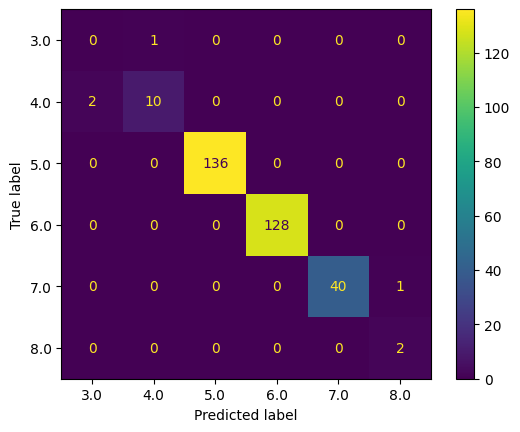

In [192]:

#excluded outliers in training, but tested on them. Our model can tell when a wine is 
#different

conf_mat(pred_4567, le.fit_transform(test_df["quality"]))

How do I identify outliers before hand, this way I can know the right model to pass the data point to? Do i use probability score obtained from the first model, heuristics to determine which ones to pass to the model?

## Oversampling

From the breakdown of the confusion matrix, it is obvious that there are lots of errors. The model does not handle minority labels(labels with little data points) properly, despite randomized search to find best parameters for Xgb boost classifier.

<Axes: ylabel='Count'>

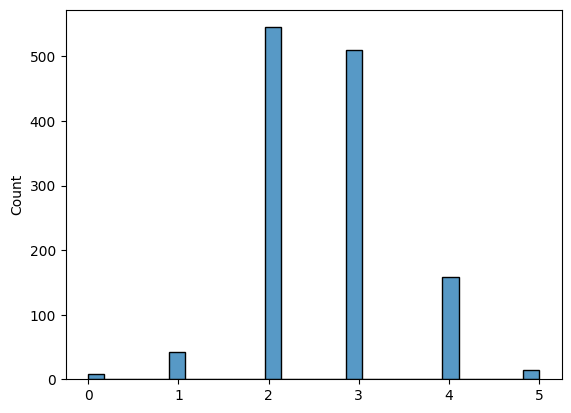

In [ ]:
#Before oversampling
sns.histplot(y)

In [ ]:
x_ = train_red_wine_df.drop(columns="quality", axis = 1)
y_ = train_red_wine_df['quality']

#Oversampling with Smote generates noisy data
sm = SMOTEENN(sampling_strategy = "auto",random_state= 42)
new_x,new_y = sm.fit_resample(x_,y_)

<Axes: xlabel='quality', ylabel='Count'>

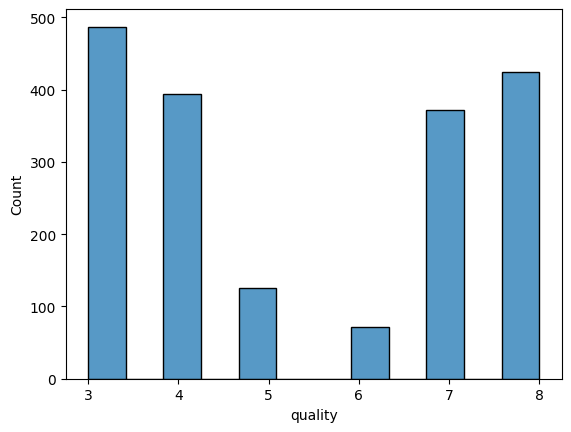

In [ ]:
sns.histplot(new_y)

In [234]:
len(train_red_wine_df), len(new_y)

NameError: name 'new_y' is not defined

<Axes: xlabel='quality', ylabel='Count'>

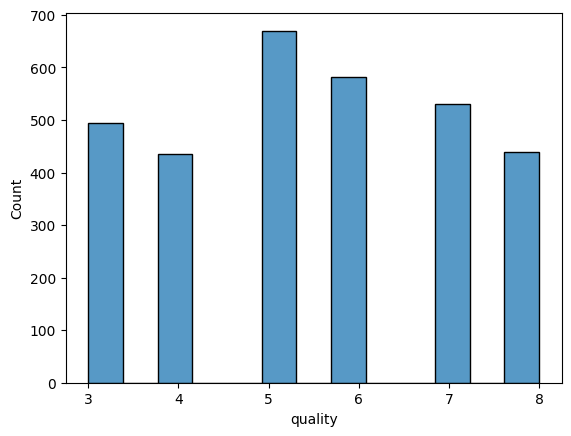

In [ ]:
new_x = pd.concat((x_,new_x), axis= 0)
new_y = pd.concat((y_, new_y), axis = 0)

sns.histplot(new_y)
#np.vstack(x_.to_numpy(), new_x)

In [ ]:
new_y = le.fit_transform(new_y)
res, pred = random_search(xgc_model, x = new_x, y = new_y)

/Users/max/Desktop/Tabular_data/tabular_venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
res

[(0.404889596816029,
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.7, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.05, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=6, max_leaves=None,
                min_child_weight=4, missing=nan, monotone_constraints=None,
                n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,
                objective='multi:softprob', ...))]

Oversampling gives a worse result, perhaps due to the noise from upsample data points

In [ ]:
train_red_wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
460,11.6,0.580,0.66,2.2,0.074,10.0,47.0,1.00080,3.25,0.57,9.00,3.0
833,10.4,0.440,0.42,1.5,0.145,34.0,48.0,0.99832,3.38,0.86,9.90,3.0
1375,6.8,0.815,0.00,1.2,0.267,16.0,29.0,0.99471,3.32,0.51,9.80,3.0
1506,6.7,0.760,0.02,1.8,0.078,6.0,12.0,0.99600,3.55,0.63,9.95,3.0
1479,7.1,0.875,0.05,5.7,0.082,3.0,14.0,0.99808,3.40,0.52,10.20,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1404,7.2,0.330,0.33,1.7,0.061,3.0,13.0,0.99600,3.23,1.10,10.00,8.0
829,7.8,0.570,0.09,2.3,0.065,34.0,45.0,0.99417,3.46,0.74,12.70,8.0
1062,9.1,0.400,0.50,1.8,0.071,7.0,16.0,0.99462,3.21,0.69,12.50,8.0
482,9.4,0.300,0.56,2.8,0.080,6.0,17.0,0.99640,3.15,0.92,11.70,8.0


## Pca

This indicates that from the density alone of the wine does not determine the quality

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 1)

#decomposing certain amount of data
new_columns = ['residual sugar',"chlorides","free sulfur dioxide", "total sulfur dioxide", "pH", "sulphates", 'quality','alcohol']
new_columns_2 = ['volatile acidity', 'residual sugar',"chlorides", "pH", "sulphates", 'quality','alcohol','fixed acidity', 'citric acid']
new_columns_3 = ['volatile acidity', "pH", "free sulfur dioxide", "total sulfur dioxide", 'quality','alcohol','fixed acidity', 'citric acid']

#decomposed citric acidity, density, fixed acidity for train data
acidity_decomp = pca.fit_transform(SS_train_red_wine_df, y = [new_columns])
sulfur_decomp = pca.fit_transform(SS_train_red_wine_df, y = [new_columns_2])
non_metals_decomp = pca.fit_transform(SS_train_red_wine_df, y = [new_columns_3])

#decomposed citric acidity, density, fixed acidity for test data
acidity_decomp_1 = pca.fit_transform(SS_test_df, y = [new_columns])
sulfur_decomp_1 = pca.fit_transform(SS_test_df, y = [new_columns_2])
non_metals_decomp_1 = pca.fit_transform(SS_test_df, y = [new_columns_3])

SS_train_red_wine_df = SS_train_red_wine_df[new_columns]

#Re creating train dataframe with decomped data
SS_train_red_wine_df['acidity_decomp'] = acidity_decomp
SS_train_red_wine_df['sulfur_decomp'] = sulfur_decomp
SS_train_red_wine_df['non_metals_decomp'] = non_metals_decomp

SS_test_df = SS_test_df[new_columns]

#Re creating test dataframe with decomped data
SS_test_df['acidity_decomp'] = acidity_decomp_1
SS_test_df['sulfur_decomp'] = sulfur_decomp_1
SS_test_df['non_metals_decomp'] = non_metals_decomp_1

In [ ]:
y_train = np.array(SS_train_red_wine_df['quality'])
x_train = np.array(SS_train_red_wine_df[["pH", "alcohol", "acidity_decomp", "sulfur_decomp", "non_metals_decomp"]])

y_test = np.array(SS_test_df['quality'])
x_test = np.array(SS_test_df[["pH", "alcohol", "acidity_decomp", "sulfur_decomp", "non_metals_decomp"]])

In [ ]:
def conv(a):
    out = {'3': 0, '4': 1, '5': 2, '6' : 3, '7': 4, '8': 5}
    return out.get(a) 

y_test = [conv(x) for x in y_test]; y_test = np.array(y_test)
y_train = [conv(x) for x in y_train]; y_train = np.array(y_train)

## **Modelling as a Linear Regression task**

WITH STANDARDIZED COLUMNS

In [ ]:
size = [0.5,0.4,0.3,0.2,0.1] #varying test and train_size
yvalues_test = {}; intercept = {}; predictions = {}; coeff = {}; xvalues_test = {}; rmse = {}
lr_model = LinearRegression()

current = 1

#x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = current)
lr_model.fit(x_train,y_train)
w = lr_model.coef_; b = lr_model.intercept_; coeff[current] = w; intercept[current] = b

#predict output based on this model
predictions = lr_model.predict(x_test)


#predictions = np.round(predictions)
#predictions = np.int0(predictions)

In [ ]:
mse_lr = {}; mae_lr = {}; rmse_lr = {}; acc = {}

mse_lr[current] = metrics.mean_squared_error(predictions, y_test)
mae_lr[current] = metrics.mean_absolute_error(predictions, y_test)
rmse_lr[current] = np.sqrt(metrics.mean_absolute_error(predictions, y_test))
acc[current] = metrics.accuracy_score(predictions, y_test)

In [ ]:
predictions, np.array(y_test)

(array([3.09850076, 2.80676465, 2.82714131, 2.92529003, 3.09698316,
        3.11194979, 3.06010416, 3.11158948, 3.81851169, 3.14410494,
        2.94342968, 2.79500065, 2.84747642, 2.90554556, 3.07385098,
        3.1911706 , 2.90461354, 3.28785886, 3.22247639, 3.21483153,
        3.10174058, 3.10078383, 3.13038978, 2.96235965, 3.17104403,
        3.05703053, 3.03856283, 2.97706467, 3.6386153 , 4.21709629,
        3.13649098, 3.04908603, 3.02839972, 3.050867  , 2.93476588,
        3.0267562 , 2.9365431 , 3.16429936, 3.11740555, 2.98447247,
        2.90555768, 3.09246772, 3.02177756, 3.01004347, 3.35165837,
        2.86851451, 3.18625206, 3.1579427 , 2.78639432, 2.94237828,
        3.40262162, 4.09525815, 3.21194409, 3.12104482, 3.00509407,
        3.21277254, 3.04434703, 3.10321885, 2.94615071, 2.88251486,
        3.10734582, 3.0685496 , 3.05356078, 2.80935425, 2.81815309,
        3.08971753, 3.09024763, 3.6394542 , 3.06093331, 3.34172281,
        2.87245545, 2.98489624, 2.92071052, 2.68

Linear Model gives result without bounds. It may be better to model this as a multi-class classification instead of a linear model. Using XGBoost on Linear Models 

XGBOOST Regressor

SPLIT,SHUFFLE

In [ ]:
xg_model = XGBRegressor()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

#xgb_grid = GridSearchCV(xg_model, parameters, n_jobs = 10)
#xgb_grid.fit(x_train_wine,y_train_wine)
#best_xg_model = XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.03, max_depth = 7, min_child_weight = 4, n_estimators = 500, nthread = 4, subsample = 0.7)

In [ ]:
#cross validation
def cross_val_w_gridsearch(x, y, model, cv_method,params, num_of_splits = 8, method = "grid"):

    """Already defined splits, x-labels are ndarrays and
    Model is already initialised y - labels are also ndarrays"""
    
    output = []
    try:
        kf = cv_method(num_of_splits, shuffle = True, random_state = 10 )
        splits = kf.split(y)
    except ModuleNotFoundError:
        print("Import {} module".format(cv_method))
    
    if method.lower() == "grid" or "random":
        print(method)
        gridsearch = GridSearchCV(model, params, n_jobs = 10) 

        for train,val in splits:    

            gridsearch.fit(x[train],y[train])
            best_xgb_model = model.set_params(**gridsearch.best_params_)

            best_xgb_model.fit(x[train], y[train])
            pred = best_xgb_model.predict(x[val])

            pred = np.round(pred, 0) #rounded up in order to match labels
            ref =  y[val]

            #using accuracy as a metric to evaluate models
            f1 = f1_score(pred,ref, average = "weighted")
            output.append((f1,best_xgb_model,))
    else:
        print("select either 'grid' or 'random'")
    return output

K-FOLD CROSS VALIDATION WITH 8 FOLDS

In [ ]:
#cross check input
pred = cross_val_w_gridsearch(x_train, y_train, xg_model, KFold, parameters, method = "grid")

grid


In [ ]:
pred = sorted(pred, key = operator.itemgetter(0), reverse=False)

high_acc_model = pred[-1][1]

In [ ]:
high_acc_model.fit(x_train,y_train)

predictions = high_acc_model.predict(x_test)
predictions = np.int0(np.round(predictions,0))

#predictions
f1_score(predictions, np.int0(y_test), average = "weighted")

0.5675288146856645

KFOLD CROSS VALIDATION WITH 10 FOLDS

In [ ]:
pred_2 = cross_val_w_gridsearch(x_train, y_train, xg_model, KFold, parameters, 10, method = "grid")
pred_2  = sorted(pred, key = operator.itemgetter(0), reverse=False)

grid


In [ ]:
high_acc_model_2 = pred_2[-1][1]

predictions_2 = high_acc_model_2.predict(x_test)
predictions_2 = np.int0(np.round(predictions_2, 0))
predictions_2
f1_score(predictions_2, y_test, average = "weighted")

0.5338184019370461

In [ ]:
xgc_model = XGBClassifier()

pred_4 = cross_val_w_gridsearch(x_train, y_train, xgc_model, KFold, parameters, method = "grid")
pred_4  = sorted(pred, key = operator.itemgetter(0), reverse=False)


grid


/Users/max/Desktop/Wine_equality_/temp_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/max/Desktop/Wine_equality_/temp_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/max/Desktop/Wine_equality_/temp_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/max/Desktop/Wine_equality_/temp_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/max/Desktop/Wine_equality_/temp_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: Us

In [ ]:
high_acc_model_4 = pred_4[-1][1]
predictions_4 = high_acc_model_4.predict(x_test)
predictions_4 = np.int0(np.round(predictions, 0))

f1_score(predictions_4, y_test, average = "weighted")

0.5675288146856645

RANDOMFOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
param = {'n_estimators': [500],
        'max_depth': [3,5,7,9],
        'min_samples_split': [2,3,4],
        'min_samples_leaf': [1,3,5,7],
        'n_jobs': [300] 
        }

In [ ]:
#cross check input
rf_model = RandomForestRegressor()

pred_3 = cross_val_w_gridsearch(x_train_wine, y_train_wine, rf_model, KFold, param, method = "grid")
pred_3 = sorted(pred_3, key = operator.itemgetter(0), reverse = False)

pred_3

grid


/Users/max/Desktop/Wine_equality_/temp_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/max/Desktop/Wine_equality_/temp_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/max/Desktop/Wine_equality_/temp_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/max/Desktop/Wine_equality_/temp_env/lib

[(0.5625,
  RandomForestRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=3,
                        n_estimators=500, n_jobs=300)),
 (0.6375,
  RandomForestRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=3,
                        n_estimators=500, n_jobs=300)),
 (0.6375,
  RandomForestRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=3,
                        n_estimators=500, n_jobs=300)),
 (0.65,
  RandomForestRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=3,
                        n_estimators=500, n_jobs=300)),
 (0.65625,
  RandomForestRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=3,
                        n_estimators=500, n_jobs=300)),
 (0.660377358490566,
  RandomForestRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=3,
                        n_estimators=500, n_jobs=300)),
 (0.6792452830188679,
  RandomForestRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=3,
                        n_

In [ ]:
high_acc_model_3 = pred_3[-1][1]

high_acc_model_3.fit(x_train_wine, y_train_wine)
predictions_3 = high_acc_model_3.predict(x_test_wine)
predictions_3 = np.round(predictions_3, 0)

accuracy_score(predictions_3, y_test_wine)

/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_44914/1663624654.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  high_acc_model_3.fit(x_train_wine, y_train_wine)


0.6363636363636364

## Detecting outliers for exclusion